In [1]:
import random
import pandas as pd
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = '/content/drive/MyDrive/MyDatasetFolder/vodclickstream_uk_movies_03.csv'

In [3]:
# Load the dataframe
df_movies = pd.read_csv(file_path)

In [4]:
df_movies.columns


Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

# Exercise 1

## 1.1 Gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks.

In [5]:
# Create a vairable named 'movie counts'where I group by 'user_id' and 'movie_id', and count occurrences
movie_counts = df_movies.groupby(['user_id', 'movie_id']).size().reset_index(name='count')

# Rank movies for each user group and filter for top 10 by count
movie_counts['rank'] = movie_counts.groupby('user_id')['count'].rank(ascending=False, method='first')
top_movies = movie_counts[movie_counts['rank'] <= 10]

# Merge with original DataFrame for movie details and select relevant columns 'user_id', 'count', 'movie_id', 'title', 'genres'
df_top10 = (top_movies.merge(df_movies, on=['user_id', 'movie_id'])
            [['user_id', 'count', 'movie_id', 'title', 'genres']])

# Drop duplicate rows, this is because it showed all the occurrance of each click.
df_top10 = df_top10.drop_duplicates(subset=['user_id', 'movie_id'])

df_top10


,user_id,count,movie_id,title,genres
0,00004e2862,1,9bfee795ff,Hannibal,"Crime, Drama, Thriller"
1,000052a0a0,1,43bb6de314,Green Room,"Horror, Music, Thriller"
2,000052a0a0,9,4718f9963c,Looper,"Action, Drama, Sci-Fi, Thriller"
11,000052a0a0,3,4fa0b092d6,Jumanji,"Adventure, Comedy, Family, Fantasy"
14,000052a0a0,1,59d313ed8b,Ant-Man,"Action, Adventure, Comedy, Sci-Fi"
...,...,...,...,...,...
613388,fffeac83be,2,cb6d7afd76,Amanda Knox,"Documentary, Crime"
613390,fffeac83be,1,dda0eae17b,Enemy at the Gates,"Drama, History, War"
613391,ffff2c5f9e,1,6467fee6b6,Hot Fuzz,"Action, Comedy, Mystery, Thriller"
613392,ffff2c5f9e,1,9ab62a3f2c,Forks Over Knives,Documentary


## 1.2 Minhash Signatures

---

### Create **mapping** of each genre and its associated id

---


This is useful because I can later on work with more simplicity when associating genres to movies

In [6]:
# First I deleted genre 'NOT AVAILABLE' because it would have messed the outcomes. Two users having NOT AVAILABLE in common are not more likely to have similar preferences in genres.
df_movies_filtered = df_movies[df_movies['genres'] != 'NOT AVAILABLE'].copy()

# make a column in df_movies_filtered named 'genres_list'
df_movies_filtered['genres_list'] = df_movies_filtered.genres.apply(lambda row: [word.strip() for word in row.split(',')])

# Initialize unique_genres var
unique_genres = set()

# fill unique_genres
df_movies_filtered['genres_list'].apply(lambda row: [unique_genres.add(value) for value in row])

# Convert unique_genres to a dictionary with IDs
mapping = {genre: genre_id for genre_id, genre in enumerate(unique_genres)}

print(mapping)


{'Romance': 0, 'Musical': 1, 'Crime': 2, 'Western': 3, 'Drama': 4, 'Family': 5, 'News': 6, 'Comedy': 7, 'Animation': 8, 'Documentary': 9, 'War': 10, 'Sport': 11, 'Action': 12, 'Horror': 13, 'Adventure': 14, 'Music': 15, 'Short': 16, 'Biography': 17, 'History': 18, 'Film-Noir': 19, 'Fantasy': 20, 'Sci-Fi': 21, 'Reality-TV': 22, 'Talk-Show': 23, 'Thriller': 24, 'Mystery': 25}


### Make a list of genres watched by each user_id and associate it to the mapping

---



In [7]:
# Initialize dictionary named user_genres in which we will have key = user_id and value = list of unique genres watched
user_genres = {}

# Iterate through each row in df_movies_filtered
for index, row in df_movies_filtered.iterrows():
    # Extract the user ID and genres list from the row which is currently iterating
    user_id = row['user_id']
    genres_list = row['genres_list']

    # Check if user ID is not already in user_genres
    if user_id not in user_genres:
        # If not, add user ID as the key and the value is a list of unique genre IDs ensuring that the genre is a string and removing any duplicates
        user_genres[user_id] = list(set(mapping[genre.strip()] for genre in genres_list if isinstance(genre, str)))
    else:
        # If the user ID already exists in the dictionary, extend the existing genre list with new genre IDs from the current row, avoiding duplicates
        user_genres[user_id].extend(
            genre_id for genre_id in set(mapping[genre.strip()] for genre in genres_list if isinstance(genre, str))
            if genre_id not in user_genres[user_id]
        )

# Print the first 5 entries in user_genres to show it works
for user_id, genres_list in list(user_genres.items())[:5]:
    print(f"User ID: {user_id}, Genres List: {genres_list}")


User ID: 1dea19f6fe, Genres List: [0, 4, 7]
User ID: 544dcbc510, Genres List: [24, 25, 20, 13, 0, 7, 4, 14]
User ID: 7cbcc791bf, Genres List: [24, 12, 2, 14, 7, 0, 5, 8, 20]
User ID: ebf43c36b6, Genres List: [12, 4, 5, 8, 14, 20, 2, 17, 24, 21, 7]
User ID: a57c992287, Genres List: [5, 7, 8, 12, 14, 20, 24, 25, 4, 21, 17, 10, 11, 2, 16, 13, 15, 18, 3, 9]


## Create Minhash Signature

In [8]:
import random

# Here a make permutations of the order of 0 to 25. We wil the associate this order to our mapping
n_permutations = 100
min_value = 0
max_value = 25

# Initialize minhash_signatures in which we will record the first value for each permutation which is inlcuded in the user set
minhash_signatures = {}
permutations = [random.sample(range(min_value, max_value + 1), max_value + 1) for _ in range(n_permutations)]
print(permutations, "/n")

# Iterate over the range of permutations
for n in range(1, n_permutations + 1):
    minhash_signatures[n] = []  # Initialize an empty list for each permutation in the minhash_signatures where n is the n of the permutation

    for user_id, genres_list in user_genres.items():
        # Check if any value in the current permutation is in the user's genres list
        for i, permutation in enumerate(permutations[n - 1]):
            if permutation in genres_list:
                # If found, append the user ID and the matching permutation value to the signatures and break so that we will get the first genre to appear in the permutations which has been seen by the user
                minhash_signatures[n].append((user_id, permutation))
                break

# minhash_ginature is too big I will only show a snippet
for n in range(1, 5):
    if minhash_signatures[n]:
        print(f"minhash_signatures[{n}]: {minhash_signatures[n][:3]}")
    else:
        print(f"minhash_signatures[{n}]: No matches found")


[[25, 8, 4, 1, 22, 20, 0, 18, 9, 7, 15, 19, 17, 14, 11, 3, 16, 23, 12, 21, 24, 5, 6, 10, 13, 2], [16, 20, 1, 19, 24, 13, 11, 3, 4, 18, 2, 9, 21, 22, 10, 15, 5, 23, 7, 8, 6, 17, 0, 14, 25, 12], [18, 7, 23, 3, 17, 24, 20, 13, 12, 8, 4, 25, 15, 0, 16, 11, 5, 14, 2, 10, 22, 6, 21, 9, 1, 19], [11, 2, 21, 15, 6, 5, 7, 19, 24, 20, 4, 22, 1, 10, 14, 25, 8, 12, 23, 18, 16, 0, 17, 13, 3, 9], [21, 23, 5, 10, 7, 2, 1, 9, 8, 17, 20, 25, 13, 16, 18, 19, 6, 24, 22, 12, 11, 4, 15, 3, 14, 0], [18, 15, 6, 14, 7, 19, 16, 17, 22, 2, 10, 13, 9, 3, 0, 20, 24, 11, 12, 21, 23, 5, 4, 25, 8, 1], [0, 16, 8, 24, 3, 17, 5, 9, 2, 22, 13, 15, 23, 1, 14, 10, 6, 12, 19, 11, 21, 4, 18, 20, 25, 7], [3, 10, 14, 11, 7, 5, 6, 8, 19, 0, 21, 1, 20, 15, 25, 4, 17, 13, 18, 16, 23, 22, 2, 12, 24, 9], [14, 22, 1, 23, 16, 20, 17, 18, 11, 10, 25, 8, 7, 2, 12, 13, 24, 15, 3, 0, 6, 19, 21, 5, 4, 9], [1, 9, 20, 6, 12, 5, 2, 17, 25, 21, 0, 24, 10, 15, 11, 19, 23, 22, 8, 18, 3, 7, 13, 4, 14, 16], [20, 8, 10, 14, 5, 0, 9, 18, 1, 17, 22,

It is correct, user id 1dea19f6fe watches "Drama" (0), "Romance" (1) and "Commedy" (14). As you can see in the first permutation it gets 14 as it's the first genre that appears, also on the second permutation while in the third one the genre 1 (Romance) appears first.

## 1.3 Locality-Sensitive Hashing (LSH)

In [9]:
input_user_id = 'a57c992287'  # user id to comapre

input_user_signature = [] # signature of input id
other_users_signatures = {} # signatures of other user id

# Iterate over each permutation's signatures in minhash_signatures
for _, tuples in minhash_signatures.items():
  for user_id, signature in tuples:
    # Check if the user_id matches our input user
    if user_id == input_user_id:
      # add the signature to the input user's signature list
      input_user_signature.append(signature)
    else:
      # Check if the user_id is already in other_users_signatures
      if user_id not in other_users_signatures:
        other_users_signatures[user_id] = []
      # Append the signature to the existing list for the user
      other_users_signatures[user_id].append(signature)

# Calculate the similarity score for each user how many times the got the same minhash value / total number of permutations
similarity_scores = {}

for user_id, other_user_signature in other_users_signatures.items():
    count_common_values = sum(1 for i, j in zip(other_user_signature, input_user_signature) if i == j)
    similarity_score = count_common_values / len(input_user_signature)
    similarity_scores[user_id] = similarity_score

# Sort similarity_scores by values in descending order
sorted_similarity_scores = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# Top 2 users
top_2_users = sorted_similarity_scores[:2]
top_2_users_id = [item[0] for item in top_2_users] # Variable which we will use later. List of user_id

print("Top 2 Similarity Scores:")
for user_id, similarity_score in top_2_users:
    print(f"User ID: {user_id}, Similarity Score: {similarity_score}")



Top 2 Similarity Scores:
User ID: f76ecc2439, Similarity Score: 0.93
User ID: ec9f1ee809, Similarity Score: 0.92


In [10]:
# make a filtered df for user in the top_2_users_id list called similar_movies_clicks
similar_movies_clicks = df_movies[df_movies['user_id'].isin(top_2_users_id)]

# count occurrances
movie_id_counts_similar = similar_movies_clicks.groupby(['user_id', 'movie_id', 'title']).size().reset_index(name='count')

# I chose to use sets in order to use the intersection functionlater
user_a = set()
user_b = set()

# movies whatched by a in user_a
filtered_df_a = movie_id_counts_similar[movie_id_counts_similar['user_id'] == top_2_users_id[0]]
user_a.update(filtered_df_a['movie_id'].unique())

# movies whatched by b in user_b
filtered_df_b = movie_id_counts_similar[movie_id_counts_similar['user_id'] == top_2_users_id[1]]
user_b.update(filtered_df_b['movie_id'].unique())

# use the intersection function to see those in common between a and b
similar_common_movies = list(user_a.intersection(user_b))
similar_noncommon_movies = list(user_a.union(user_b))

# list in descending order by click the movies seen by both a and b and those watched indiviually by them
result_common = movie_id_counts_similar[movie_id_counts_similar['movie_id'].isin(similar_common_movies)].groupby(['title']).agg({'count': 'sum'}).reset_index().sort_values(by='count', ascending=False)
result_noncommon = movie_id_counts_similar[movie_id_counts_similar['movie_id'].isin(similar_noncommon_movies)].sort_values(by='count', ascending=False)[['title', 'count']]

# concatenate so that we will first see the ones in result_common (seen by both) and then the once which they did not both see
concatenated_result = pd.concat([result_common, result_noncommon])

# show top 5 movies
concatenated_result.head(5)


,title,count
59,Nerdland,10
42,Exodus: Gods and Kings,5
25,The Avengers,4
16,Star Wars: The Force Awakens,4
28,Arthur Christmas,4


# 2. Grouping Users together!

Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

## 2.1 Getting your data + feature engineering

In [11]:
df = pd.read_csv(file_path)
df.shape

(671736, 8)

In [12]:
df_copy = df.copy()

In [13]:
#### Convert datetime columns from string to datetime

df.datetime = pd.to_datetime(df.datetime)
df.release_date = pd.to_datetime(df.release_date, errors='coerce')

In [14]:
df['genre_list'] = df['genres'].str.split(', ')


In [15]:
# Explode the DataFrame based on the 'genre_list' column to have one row for each genre
exploded_df = df.explode('genre_list')

# Group by user and genre to calculate total time spent on each genre
user_genre_time = exploded_df.groupby(['user_id', 'genre_list'])['duration'].sum().reset_index()

# Find the favorite genre for each user (the genre they spent the most time on)
user_favorite_genre = user_genre_time.loc[user_genre_time.groupby('user_id')['duration'].idxmax()]

### Feature Engineering


Favorite genre (i.e., the genre on which the user spent the most time) (Feature 1)

In [16]:
user_favorite_genre = user_favorite_genre[["user_id", "genre_list"]]

user_favorite_genre

,user_id,genre_list
0,00004e2862,Crime
3,000052a0a0,Action
17,000090e7c8,Mystery
20,000118a755,Horror
22,000296842d,Drama
...,...,...
861713,fffd9bf758,Crime
861716,fffe7b777b,Drama
861723,fffeac83be,Drama
861728,ffff2c5f9e,Action


Average click duration (Feature 2)


In [17]:
user_avg_duration = df.groupby('user_id')['duration'].mean().reset_index()
user_avg_duration.columns = ['user_id', 'avg_duration']

In [18]:
user_avg_duration

,user_id,avg_duration
0,00004e2862,0.000000
1,000052a0a0,2024.166667
2,000090e7c8,0.000000
3,000118a755,-0.250000
4,000296842d,9663.375000
...,...,...
161913,fffd9bf758,8495.000000
161914,fffe7b777b,1785.000000
161915,fffeac83be,40606.272727
161916,ffff2c5f9e,0.000000


Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks) (Feature 3)

In [19]:
df['time_of_day'] = df['datetime'].dt.hour.apply(lambda x: 'Morning' if 5 <= x < 12 else 'Afternoon' if 12 <= x < 18 else 'Night')
user_time_spent = df.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# Getting the index of maximum duration for each user
idx = user_time_spent.groupby('user_id')['duration'].idxmax()

# Selecting the time of day with the maximum duration for each user
user_most_time_spent = user_time_spent.loc[idx]

In [20]:
user_most_time_spent = user_most_time_spent[["user_id", "time_of_day"]]
user_most_time_spent

,user_id,time_of_day
0,00004e2862,Night
3,000052a0a0,Night
4,000090e7c8,Night
5,000118a755,Night
6,000296842d,Night
...,...,...
237446,fffd9bf758,Night
237447,fffe7b777b,Afternoon
237449,fffeac83be,Night
237450,ffff2c5f9e,Afternoon


Is the user an old movie lover, or is he into more recent stuff (content released after 2010)? (Feature 4)

In [21]:
df['era'] = df['release_date'].dt.year.apply(lambda x: 'Old' if x < 2010 else 'New')

# Get unique movie counts for each user in each era
user_movie_counts = df.groupby(['user_id', 'era'])['movie_id'].nunique().unstack(fill_value=0)

# Determine user movie preferences
user_movie_counts['era_preference'] = user_movie_counts.apply(lambda row: 'Old' if row['Old'] > row['New'] else 'New', axis=1)

user_movie_counts = user_movie_counts['era_preference'].reset_index()

In [17]:
user_movie_counts

,user_id,era_preference
0,00004e2862,Old
1,000052a0a0,New
2,000090e7c8,New
3,000118a755,New
4,000296842d,New
...,...,...
161913,fffd9bf758,New
161914,fffe7b777b,New
161915,fffeac83be,New
161916,ffff2c5f9e,New


Average time spent a day by the user (considering only the days he logs in) (Feature 5)

In [22]:
# Extract date from 'datetime'
df['date'] = df['datetime'].dt.date

# Group by user and date to calculate total time spent per day
user_daily_time = df.groupby(['user_id', 'date'])['duration'].sum().reset_index()

# Count the number of days each user logs in
user_login_days = user_daily_time.groupby('user_id')['date'].nunique().reset_index()
user_login_days.columns = ['user_id', 'login_days']

# Calculate total time spent by each user
user_total_time = user_daily_time.groupby('user_id')['duration'].sum().reset_index()

# Merge login days and total time spent dataframes
user_time_summary = pd.merge(user_total_time, user_login_days, on='user_id')

# Calculate average time spent per day
user_time_summary['avg_time_per_day'] = user_time_summary['duration'] / user_time_summary['login_days']

# ChatGPT Features


*   Total Duration of Interactions per User: Calculate the total duration of interactions by each user.
*   Number of Unique Movies Watched: Count the number of unique movies each user has interacted with.
*   Most Common Genre: Identify the most common genre for each user based on their interactions.
*   Days Since First Interaction: Calculate the number of days since the user's first interaction.
*   Days Since Last Interaction: Calculate the number of days since the user's last interaction.
*   Interaction Frequency: Calculate the average number of interactions per day for each user.
*   Longest Time Spent in a Single Session: Find the longest continuous session duration for each user.
*   Release Year of Most Interacted Movies: Identify the release year of the most interacted movies for each user.
*   Weekday vs. Weekend Interaction Ratio: Calculate the ratio of interactions on weekdays to weekends.
*   Variety of Genres Watched: Measure the variety of genres a user has interacted with (entropy or diversity index).









In [23]:
user_time_summary = user_time_summary[["user_id", "avg_time_per_day"]]
user_time_summary

,user_id,avg_time_per_day
0,00004e2862,0.000
1,000052a0a0,4858.000
2,000090e7c8,0.000
3,000118a755,-0.500
4,000296842d,38653.500
...,...,...
161913,fffd9bf758,8495.000
161914,fffe7b777b,1785.000
161915,fffeac83be,55833.625
161916,ffff2c5f9e,0.000


In [24]:
# Total Duration of Interactions per User
user_total_duration = df.groupby('user_id')['duration'].sum().reset_index()
user_total_duration.columns = ['user_id', 'total_duration']

In [25]:
user_total_duration


,user_id,total_duration
0,00004e2862,0.0
1,000052a0a0,48580.0
2,000090e7c8,0.0
3,000118a755,-1.0
4,000296842d,77307.0
...,...,...
161913,fffd9bf758,8495.0
161914,fffe7b777b,1785.0
161915,fffeac83be,446669.0
161916,ffff2c5f9e,0.0


Average click duration (Feature 2)

In [26]:
# 2. Number of Unique Movies Watched
user_unique_movies = df.groupby('user_id')['movie_id'].nunique().reset_index()
user_unique_movies.columns = ['user_id', 'num_unique_movies']

In [27]:
user_unique_movies


,user_id,num_unique_movies
0,00004e2862,1
1,000052a0a0,11
2,000090e7c8,1
3,000118a755,2
4,000296842d,1
...,...,...
161913,fffd9bf758,1
161914,fffe7b777b,1
161915,fffeac83be,10
161916,ffff2c5f9e,2


In [28]:
# 3. Most Common Genre
user_most_common_genre = df.groupby('user_id')['genres'].agg(lambda x: pd.Series.mode(x).iat[0] if len(pd.Series.mode(x)) > 0 else 'None').reset_index()
user_most_common_genre.columns = ['user_id', 'most_common_genre']

In [29]:
user_most_common_genre

,user_id,most_common_genre
0,00004e2862,"Crime, Drama, Thriller"
1,000052a0a0,"Action, Drama, Sci-Fi, Thriller"
2,000090e7c8,"Mystery, Sci-Fi, Thriller"
3,000118a755,NOT AVAILABLE
4,000296842d,"Drama, Mystery, Sci-Fi, Thriller"
...,...,...
161913,fffd9bf758,"Documentary, Crime, Mystery"
161914,fffe7b777b,"Drama, Sci-Fi, Thriller"
161915,fffeac83be,"Documentary, Crime"
161916,ffff2c5f9e,"Action, Comedy, Mystery, Thriller"


In [30]:
# 4. Days Since First Interaction
user_first_interaction = df.groupby('user_id')['datetime'].min().reset_index()
user_first_interaction['days_since_first_interaction'] = (df['datetime'].max() - user_first_interaction['datetime']).dt.days

In [31]:
user_first_interaction


,user_id,datetime,days_since_first_interaction
0,00004e2862,2017-12-05 20:39:15,572
1,000052a0a0,2017-05-23 18:41:44,768
2,000090e7c8,2018-03-09 20:01:40,478
3,000118a755,2018-06-14 23:19:33,381
4,000296842d,2018-12-30 22:05:13,182
...,...,...,...
161913,fffd9bf758,2017-06-21 18:06:32,739
161914,fffe7b777b,2017-08-19 17:03:18,680
161915,fffeac83be,2017-08-09 20:21:52,690
161916,ffff2c5f9e,2017-07-23 14:45:12,707


In [32]:
# 5. Days Since Last Interaction
user_last_interaction = df.groupby('user_id')['datetime'].max().reset_index()
user_last_interaction['days_since_last_interaction'] = (df['datetime'].max() - user_last_interaction['datetime']).dt.days

In [33]:
user_last_interaction


,user_id,datetime,days_since_last_interaction
0,00004e2862,2017-12-05 20:39:15,572
1,000052a0a0,2017-06-26 18:25:42,734
2,000090e7c8,2018-03-09 20:01:40,478
3,000118a755,2018-06-15 03:01:15,380
4,000296842d,2018-12-31 20:16:23,181
...,...,...,...
161913,fffd9bf758,2017-06-21 18:06:32,739
161914,fffe7b777b,2017-08-19 17:03:18,680
161915,fffeac83be,2017-09-20 21:18:18,648
161916,ffff2c5f9e,2017-07-23 15:02:43,707


In [34]:
# 6. Interaction Frequency
# Calculate Interaction Frequency considering Duration > 0
df['interaction_with_duration'] = (df['duration'] > 0).astype(int)
user_interaction_frequency = df.groupby('user_id')['interaction_with_duration'].sum().reset_index(name='num_interactions')

user_interaction_frequency['interaction_frequency'] = user_interaction_frequency['num_interactions'] / (
            (df['datetime'].max() - df['datetime'].min()).days + 1)

In [35]:
user_interaction_frequency.sort_values(by="interaction_frequency")


,user_id,num_interactions,interaction_frequency
0,00004e2862,0,0.000000
80243,7f186967c9,0,0.000000
80236,7f15ab7f83,0,0.000000
80235,7f157426ce,0,0.000000
80233,7f1463be31,0,0.000000
...,...,...,...
31702,322f2bd4d4,179,0.196487
78505,7c53ece165,186,0.204171
87092,89fbb087f3,278,0.305159
75498,779343a3ea,483,0.530187


In [36]:
# 7. Longest Time Spent in a Single Session
df['time_diff'] = df.groupby('user_id')['datetime'].diff()
df['session'] = (df['time_diff'] > pd.Timedelta('1 hour')).cumsum()

user_longest_session = df.groupby(['user_id', 'session'])['duration'].sum().reset_index()
user_longest_session = user_longest_session.groupby('user_id')['duration'].max().reset_index()
user_longest_session.columns = ['user_id', 'longest_session_duration']

In [37]:
user_longest_session


,user_id,longest_session_duration
0,00004e2862,0.0
1,000052a0a0,7857.0
2,000090e7c8,0.0
3,000118a755,0.0
4,000296842d,62860.0
...,...,...
161913,fffd9bf758,8495.0
161914,fffe7b777b,1785.0
161915,fffeac83be,173436.0
161916,ffff2c5f9e,0.0


In [38]:
# 8. Release Year of Most Interacted Movies
def get_mode_release_year(x):
    try:
        return x.dt.year.mode().iat[0]
    except IndexError:
        return None

user_most_interacted_movie_year = df.groupby('user_id')['release_date'].apply(get_mode_release_year).reset_index()
user_most_interacted_movie_year.columns = ['user_id', 'release_year_most_interacted']

In [39]:
user_most_interacted_movie_year


,user_id,release_year_most_interacted
0,00004e2862,2001.0
1,000052a0a0,2012.0
2,000090e7c8,2018.0
3,000118a755,1976.0
4,000296842d,2018.0
...,...,...
161913,fffd9bf758,2015.0
161914,fffe7b777b,2017.0
161915,fffeac83be,2015.0
161916,ffff2c5f9e,2007.0


In [40]:
# 9. Weekday vs. Weekend Interaction Ratio
df['weekday'] = df['datetime'].dt.weekday < 5
user_weekday_ratio = df.groupby('user_id')['weekday'].mean().reset_index()
user_weekday_ratio.columns = ['user_id', 'weekday_interaction_ratio']

In [41]:
user_weekday_ratio


,user_id,weekday_interaction_ratio
0,00004e2862,1.000000
1,000052a0a0,0.541667
2,000090e7c8,1.000000
3,000118a755,1.000000
4,000296842d,0.750000
...,...,...
161913,fffd9bf758,1.000000
161914,fffe7b777b,0.000000
161915,fffeac83be,0.909091
161916,ffff2c5f9e,0.000000


In [42]:
# 10. Variety of Genres Watched (Entropy or Diversity Index)
from scipy.stats import entropy

user_genre_entropy = df.groupby('user_id')['genres'].apply(lambda x: entropy(x.value_counts(normalize=True))).reset_index(name='genre_entropy')

In [43]:
user_genre_entropy

,user_id,genre_entropy
0,00004e2862,0.000000
1,000052a0a0,2.021679
2,000090e7c8,0.000000
3,000118a755,0.562335
4,000296842d,0.000000
...,...,...
161913,fffd9bf758,0.000000
161914,fffe7b777b,0.000000
161915,fffeac83be,2.145842
161916,ffff2c5f9e,0.693147


### Combine all new features


In [44]:
# Combine all new features into a single DataFrame
additional_features = [
    user_favorite_genre,
    user_avg_duration,
    user_most_time_spent,
    user_movie_counts,
    user_time_summary,
    user_avg_duration,
    user_unique_movies,
    user_most_common_genre,
    user_first_interaction[['user_id', 'days_since_first_interaction']],
    user_last_interaction[['user_id', 'days_since_last_interaction']],
    user_interaction_frequency[['user_id', 'interaction_frequency']],
    user_longest_session,
    user_most_interacted_movie_year,
    user_weekday_ratio,
    user_genre_entropy
]

# Merge with the previous DataFrame containing 15 features
features_combined = df_copy
for feature in additional_features:
    features_combined = pd.merge(features_combined, feature, on='user_id', how='left')





In [45]:
features_combined.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genre_list,avg_duration_x,...,avg_duration_y,num_unique_movies,most_common_genre,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,release_year_most_interacted,weekday_interaction_ratio,genre_entropy
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,Comedy,0.000000,...,0.000000,1,"Comedy, Drama, Romance",910,910,0.000000,0.0,2008.0,0.000000,0.000000
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,Drama,1553.750000,...,1553.750000,8,"Comedy, Romance",910,910,0.002195,10933.0,2008.0,0.000000,1.820076
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,Action,4218.666667,...,4218.666667,4,"Action, Thriller",910,907,0.004391,10530.0,2016.0,0.500000,1.242453
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,Action,1883.533333,...,1883.533333,12,"Action, Thriller",910,903,0.016465,7524.0,2016.0,0.266667,1.894312
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,Drama,3684.538462,...,3684.538462,22,"Biography, Drama, Sport, War",910,877,0.012075,56338.0,2016.0,0.807692,2.951252


## 2.2 Choose your features (variables)!


You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).
Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.
Normalization
Normalizing features is beneficial when working with algorithms sensitive to feature scales or units. For instance, models like K-Nearest Neighbors (KNN) or Support Vector Machines (SVM) can be influenced by varying feature scales. Normalization scales the features to a common range, typically between 0 and 1 or with a mean of 0 and unit variance.

In our dataset, features like 'duration', 'total_duration', and potentially 'num_interactions' might have different scales compared to other features like counts or categorical values. Normalizing these numerical features can help balance their influence on models, ensuring they contribute fairly.

In [46]:
features_combined.drop(columns="Unnamed: 0", inplace=True)
features_combined.drop(columns="avg_duration_y", inplace=True)
features_combined.rename(columns={'avg_duration_x': 'avg_duration'}, inplace=True)
features_combined["release_year_most_interacted"] = features_combined["release_year_most_interacted"].astype(str)

features_combined_pca = features_combined

In [47]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical features for normalization
numerical_features = features_combined._get_numeric_data().columns.to_list()

# Normalize the selected numerical features
scaler = MinMaxScaler()
features_combined[numerical_features] = scaler.fit_transform(features_combined[numerical_features])

In [48]:
features_combined.head()


,datetime,duration,title,genres,release_date,movie_id,user_id,genre_list,avg_duration,time_of_day,...,avg_time_per_day,num_unique_movies,most_common_genre,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,release_year_most_interacted,weekday_interaction_ratio,genre_entropy
0,2017-01-01 01:15:09,5.483282e-08,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,Comedy,8.716925e-08,Night,...,7.139020e-08,0.000000,"Comedy, Drama, Romance",1.0,1.000000,0.000000,5.483282e-08,2008.0,0.000000,0.000000
1,2017-01-01 13:56:02,5.483282e-08,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,Drama,1.355264e-04,Night,...,1.331142e-03,0.033493,"Comedy, Romance",1.0,1.000000,0.002717,5.995420e-04,2008.0,0.000000,0.438328
2,2017-01-01 15:17:47,5.774444e-04,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,Action,3.678252e-04,Night,...,6.024143e-04,0.014354,"Action, Thriller",1.0,0.996703,0.005435,5.774444e-04,2016.0,0.500000,0.299219
3,2017-01-01 16:04:13,2.741641e-06,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,Action,1.642733e-04,Afternoon,...,6.724005e-04,0.052632,"Action, Thriller",1.0,0.992308,0.020380,4.126169e-04,2016.0,0.266667,0.456206
4,2017-01-01 19:16:37,5.483282e-08,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,Drama,3.212656e-04,Night,...,5.261513e-04,0.100478,"Biography, Drama, Sport, War",1.0,0.963736,0.014946,3.089226e-03,2016.0,0.807692,0.710748


### Dimensionality Reduction:
For dimensionality reduction, considering the number of features available, Principal Component Analysis (PCA) seems appropriate. PCA is suitable for numerical features and helps in reducing the number of dimensions while retaining most of the variability in the data.

PCA identifies patterns and reduces the dimensionality by transforming the original features into a new set of uncorrelated variables called

In [49]:
from sklearn.decomposition import PCA

# Specify the features to include in PCA
features_for_pca = numerical_features

# Create a DataFrame containing only the features selected for PCA
data_for_pca = features_combined_pca[features_for_pca]

# Instantiate PCA and specify the number of components
pca = PCA(n_components=5)  # Set the number of components to retain

# Fit PCA on your data and transform it into the reduced dimensionality
pca_result = pca.fit_transform(data_for_pca)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Concatenate PCA results with other non-PCA columns if needed
final_data = pd.concat([features_combined_pca.drop(columns=features_for_pca), pca_df], axis=1)

In [50]:
final_data.head()


,datetime,title,genres,release_date,movie_id,user_id,genre_list,time_of_day,era_preference,most_common_genre,release_year_most_interacted,PC1,PC2,PC3,PC4,PC5
0,2017-01-01 01:15:09,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,Comedy,Night,Old,"Comedy, Drama, Romance",2008.0,0.670844,0.705248,-0.369933,0.038569,-0.001463
1,2017-01-01 13:56:02,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,Drama,Night,New,"Comedy, Romance",2008.0,0.692462,0.700777,0.062718,-0.031480,-0.023718
2,2017-01-01 15:17:47,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,Action,Night,New,"Action, Thriller",2016.0,0.721795,0.203573,-0.082934,-0.013069,-0.015858
3,2017-01-01 16:04:13,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,Action,Afternoon,New,"Action, Thriller",2016.0,0.708717,0.434285,0.082405,-0.009682,-0.022394
4,2017-01-01 19:16:37,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,Drama,Night,New,"Biography, Drama, Sport, War",2016.0,0.743197,-0.109296,0.333863,-0.031677,-0.013810


In [51]:
features_combined.columns


Index(['datetime', 'duration', 'title', 'genres', 'release_date', 'movie_id',
       'user_id', 'genre_list', 'avg_duration', 'time_of_day',
       'era_preference', 'avg_time_per_day', 'num_unique_movies',
       'most_common_genre', 'days_since_first_interaction',
       'days_since_last_interaction', 'interaction_frequency',
       'longest_session_duration', 'release_year_most_interacted',
       'weekday_interaction_ratio', 'genre_entropy'],
      dtype='object')

## 2.3 Clustering!


In [52]:
selected_features = ['avg_duration', 'avg_time_per_day',
                     'num_unique_movies', 'days_since_first_interaction',
                     'days_since_last_interaction', 'interaction_frequency', 'longest_session_duration',
                      'weekday_interaction_ratio', 'genre_entropy']

data_points = features_combined[selected_features].values

<Axes: >

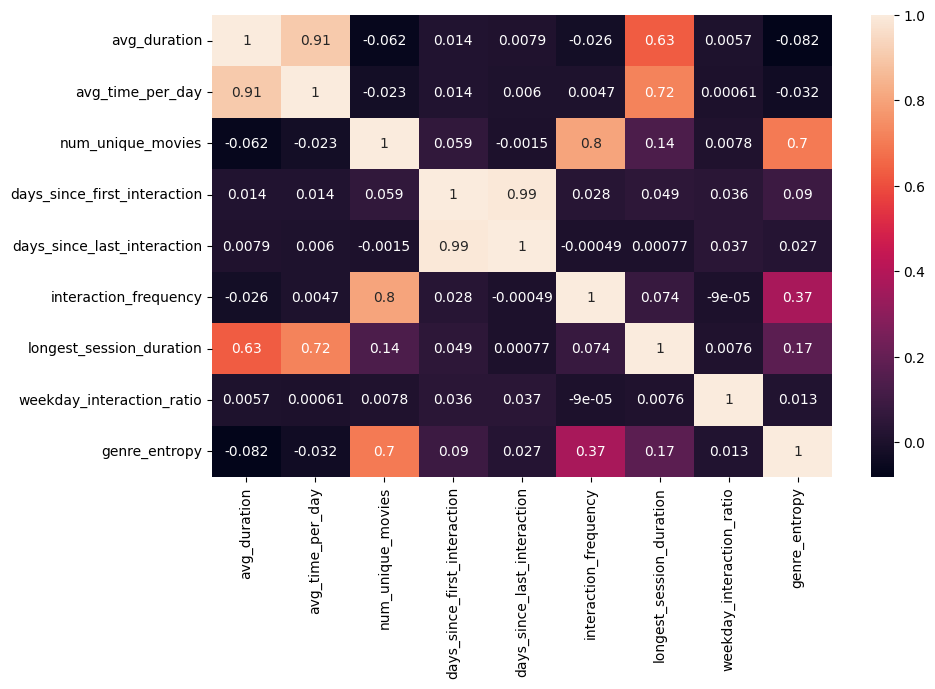

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

cor_matrix = features_combined[selected_features].corr()
sns.heatmap(cor_matrix, annot=True)

Using a correlation matrix, columns showing a correlation higher than 70% were identified and removed from the dataset. This process aimed to eliminate redundant information and improve the dataset's efficiency by reducing multicollinearity among features. Consequently, the dataset was refined to exclude columns that exhibited strong correlations, resulting in a more streamlined and potentially more effective set of features for analysis or modeling purposes.

In [54]:
df_corr = features_combined[selected_features]

# Create correlation matrix
corr_matrix = df_corr.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

# Drop features
df_corr.drop(to_drop, axis=1, inplace=True)

print("Number of remaining columns after eliminated correlated features: ", df_corr.shape[1])

df_kmeans = df_corr.values

Number of remaining columns after eliminated correlated features:  4


Elbow Method: Plot the within-cluster sum of squares (WCSS) against different values of K and look for an "elbow" point where the rate of decrease sharply changes. The point where the rate of decrease sharply decreases suggests an optimal number of clusters.

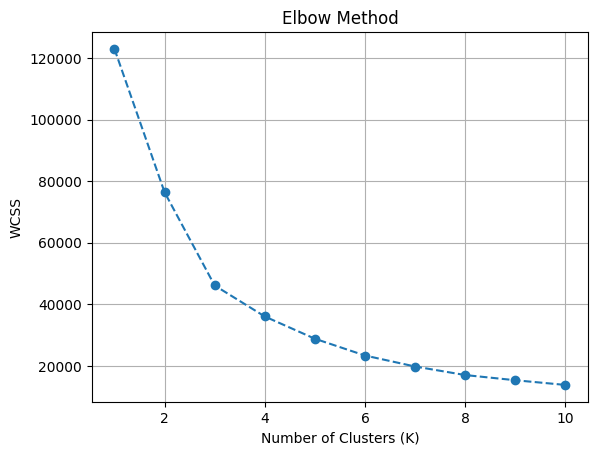

In [55]:
#Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_kmeans)
    wcss.append(kmeans.inertia_)  # inertia_ gives WCSS

plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

Silhouette Score: Calculate the silhouette score for different values of K. The silhouette score measures how similar an object is to its own cluster compared to other clusters. Higher silhouette scores indicate better-defined clusters.

In [ ]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_corr)
    silhouette_avg = silhouette_score(df_corr, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

### KMeans using MapReduce from scratch


In [56]:
# Function to initialize centroids randomly
def initialize_centroids(data, K):
    indices = np.random.choice(data.shape[0], K, replace=False)
    return data[indices]

# Mapper function: Assign each data point to the nearest centroid
def map_function(data_point, centroids):
    distances = np.linalg.norm(data_point - centroids, axis=1)
    nearest_centroid_idx = np.argmin(distances)
    return (nearest_centroid_idx, (data_point, 1))

# Reducer function: Calculate new centroids based on mean of assigned data points
def reduce_function(cluster_id, data_points):
    new_centroid = np.mean([point[0] for point in data_points], axis=0)
    return (cluster_id, new_centroid)

In [57]:
# K-means algorithm
def k_means(data, K, max_iterations=100):
    centroids = initialize_centroids(data, K)

    for _ in range(max_iterations):
        # Map phase
        mapped_data = [map_function(point, centroids) for point in data]

        # Shuffle and sort mapped data by cluster ID
        mapped_data.sort(key=lambda x: x[0])

        # Reduce phase
        reduced_data = {}
        for cluster_id, point_data in mapped_data:
            if cluster_id not in reduced_data:
                reduced_data[cluster_id] = []
            reduced_data[cluster_id].append(point_data)

        new_centroids = [reduce_function(cluster_id, points) for cluster_id, points in reduced_data.items()]
        centroids = np.array([centroid[1] for centroid in new_centroids])

    return centroids

In [58]:
# Decided Number of clusters is 3 from Elbow Method
num_clusters = 3

# Perform K-means clustering
final_centroids_df_kmeans = k_means(df_kmeans, num_clusters)
print("Final centroids:", final_centroids_df_kmeans)

Final centroids: [[0.00294611 0.02202702 0.44313154 0.18759927]
 [0.00296588 0.04907294 0.73885253 0.77594283]
 [0.00284611 0.04128203 0.23275908 0.79981203]]


In [59]:
# Assign cluster labels to each data point manually based on centroids
def assign_cluster_labels(data, centroids):
    distances = np.linalg.norm(data[:, None] - centroids, axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels

In [60]:
cluster_labels = assign_cluster_labels(df_kmeans, final_centroids_df_kmeans)

# Assign cluster labels to main data
features_combined['cluster_label_df_kmeans'] = cluster_labels

features_combined.cluster_label_df_kmeans.value_counts()

1    272185
2    241528
0    158023
Name: cluster_label_df_kmeans, dtype: int64

## Cluster Statistics


In [61]:
#Cluster 0
features_combined[features_combined['cluster_label_df_kmeans'] == 0].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans
count,1.580230e+05,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.0
mean,1.853218e-03,0.002946,0.004018,0.022027,0.443132,0.428131,0.005982,0.007536,0.187599,0.268600,0.0
std,8.898949e-03,0.009889,0.011249,0.032329,0.257293,0.257801,0.009867,0.016739,0.177983,0.197923,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,5.483282e-08,0.000050,0.000085,0.004785,0.217582,0.204396,0.001359,0.000099,0.000000,0.135427,0.0
50%,5.483282e-08,0.000539,0.000942,0.009569,0.440659,0.434066,0.002717,0.001701,0.200000,0.264578,0.0
75%,3.259811e-04,0.002209,0.003394,0.028708,0.634066,0.621978,0.006793,0.006574,0.333333,0.417325,0.0
max,4.993127e-01,0.793771,0.650086,0.397129,1.000000,1.000000,0.129076,0.499313,0.538462,0.930519,0.0


In [62]:
#Cluster 1
features_combined[features_combined['cluster_label_df_kmeans'] == 1].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans
count,2.721850e+05,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.0
mean,1.865655e-03,0.002966,0.003974,0.049073,0.738853,0.710467,0.015799,0.010516,0.775943,0.383971,1.0
std,8.695659e-03,0.008355,0.009228,0.080852,0.145660,0.148157,0.055926,0.022471,0.188225,0.222640,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.476923,0.086813,0.000000,0.000000,0.285714,0.000000,1.0
25%,5.483282e-08,0.000253,0.000403,0.009569,0.609890,0.589011,0.002717,0.000525,0.625000,0.234644,1.0
50%,2.960972e-06,0.001085,0.001774,0.023923,0.737363,0.714286,0.005435,0.004495,0.774194,0.387600,1.0
75%,3.947963e-04,0.002838,0.004075,0.057416,0.863736,0.836264,0.014946,0.011248,1.000000,0.542795,1.0
max,1.000000e+00,1.000000,0.818984,1.000000,1.000000,0.998901,1.000000,1.000000,1.000000,0.981271,1.0


In [63]:
#Cluster 2
features_combined[features_combined['cluster_label_df_kmeans'] == 2].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans
count,2.415280e+05,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.0
mean,1.790315e-03,0.002846,0.003820,0.041282,0.232759,0.212078,0.012508,0.009021,0.799812,0.344444,2.0
std,8.381230e-03,0.008537,0.010006,0.064370,0.132200,0.134108,0.035867,0.018139,0.182398,0.222875,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.002198,0.000000,0.000000,0.000000,0.388889,0.000000,2.0
25%,5.483282e-08,0.000184,0.000292,0.004785,0.119780,0.103297,0.001359,0.000386,0.655172,0.166930,2.0
50%,6.031610e-07,0.000950,0.001613,0.019139,0.213187,0.198901,0.005435,0.004074,0.800000,0.341612,2.0
75%,3.722600e-04,0.002560,0.003826,0.047847,0.347253,0.318681,0.012228,0.009547,1.000000,0.505295,2.0
max,7.680720e-01,0.610513,1.000000,0.622010,0.495604,0.495604,0.656250,0.768072,1.000000,1.000000,2.0


In [64]:
pca_result


array([[ 0.67084436,  0.70524755, -0.36993336,  0.03856856, -0.00146293],
       [ 0.69246205,  0.70077711,  0.06271774, -0.03147976, -0.02371786],
       [ 0.7217946 ,  0.20357278, -0.08293445, -0.01306859, -0.01585846],
       ...,
       [-0.67896941,  0.09408137, -0.00376326, -0.01278159, -0.0109103 ],
       [-0.68973205,  0.39303839,  0.07651497, -0.03364083, -0.00671166],
       [-0.684386  ,  0.22919262,  0.08439762, -0.02506422, -0.00595739]])

In [65]:
# Decided Number of clusters is 3 from Elbow Method
num_clusters = 3

# Perform K-means clustering
final_centroids_pca = k_means(pca_result, num_clusters)
print("Final centroids for pca:", final_centroids_pca)

Final centroids for pca: [[-1.11074062e-01  4.97690728e-01 -1.11679595e-01  2.37752830e-03
  -1.27133399e-03]
 [-3.54355858e-01 -1.55262962e-01  2.60659732e-02 -1.04077818e-03
  -5.74872873e-06]
 [ 3.59268439e-01 -7.95350468e-02  2.55505018e-02 -1.17389850e-04
   5.56412451e-04]]


In [66]:
cluster_labels_pca = assign_cluster_labels(pca_result, final_centroids_pca)

# Assign cluster labels to main data
final_data['cluster_label_pca'] = cluster_labels_pca

final_data.cluster_label_pca.value_counts()

2    290592
1    255117
0    126027
Name: cluster_label_pca, dtype: int64

In [67]:
#Cluster 0 for pca data
final_data[final_data['cluster_label_pca'] == 0].describe()

,PC1,PC2,PC3,PC4,PC5,cluster_label_pca
count,126027.000000,126027.000000,126027.000000,126027.000000,126027.000000,126027.0
mean,-0.111074,0.497691,-0.111680,0.002378,-0.001271,0.0
std,0.340344,0.170823,0.182731,0.027227,0.016991,0.0
min,-0.737405,0.046936,-0.369933,-0.052968,-0.037390,0.0
25%,-0.398298,0.348200,-0.306526,-0.020712,-0.009535,0.0
50%,-0.098276,0.596343,-0.123956,0.003051,-0.001905,0.0
75%,0.125164,0.643641,0.017107,0.035779,0.001076,0.0
max,0.692462,0.705248,0.650261,0.169625,0.490395,0.0


In [68]:
#Cluster 1 for pca data
final_data[final_data['cluster_label_pca'] == 1].describe()

,PC1,PC2,PC3,PC4,PC5,cluster_label_pca
count,255117.000000,255117.000000,255117.000000,255117.000000,255117.000000,255117.0
mean,-0.354356,-0.155263,0.026066,-0.001041,-0.000006,1.0
std,0.185467,0.199290,0.228482,0.049976,0.022156,0.0
min,-0.709355,-0.406296,-0.348672,-0.055444,-0.106186,1.0
25%,-0.510148,-0.363790,-0.157553,-0.026997,-0.010481,1.0
50%,-0.378938,-0.161556,0.027302,-0.011297,-0.003208,1.0
75%,-0.199372,0.004385,0.185641,0.011263,0.003303,1.0
max,0.027157,0.377105,0.780416,0.720728,0.901618,1.0


In [69]:
#Cluster 2 for pca data
final_data[final_data['cluster_label_pca'] == 2].describe()

,PC1,PC2,PC3,PC4,PC5,cluster_label_pca
count,290592.000000,290592.000000,290592.000000,290592.000000,290592.000000,290592.0
mean,0.359268,-0.079535,0.025551,-0.000117,0.000556,2.0
std,0.202756,0.211111,0.228959,0.072235,0.033209,0.0
min,-0.018768,-0.354753,-0.383890,-0.052743,-0.137413,2.0
25%,0.183129,-0.305198,-0.125341,-0.027638,-0.011410,2.0
50%,0.361682,-0.086616,0.026670,-0.012219,-0.004079,2.0
75%,0.530216,0.073635,0.181381,0.009141,0.002656,2.0
max,0.772068,0.699448,0.906364,1.191145,0.619356,2.0


In [70]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def kmeans_plusplus(X, k):
    centroids = []
    centroids.append(random.choice(X))

    for _ in range(1, k):
        distances = []
        for x in X:
            dist = min([euclidean_distance(x, c) for c in centroids])
            distances.append(dist)
        next_centroid = X[np.argmax(distances)]
        centroids.append(next_centroid)

    return np.array(centroids)

def kmeans_pp(X, k, max_iters=100):
    centroids = kmeans_plusplus(X, k)
    prev_centroids = np.zeros(centroids.shape)
    clusters = np.zeros(len(X))
    converged = False
    iteration = 0

    while not converged and iteration < max_iters:
        for i in range(len(X)):
            distances = [euclidean_distance(X[i], centroid) for centroid in centroids]
            cluster = np.argmin(distances)
            clusters[i] = cluster

        prev_centroids = np.copy(centroids)

        for i in range(k):
            points = [X[j] for j in range(len(X)) if clusters[j] == i]
            centroids[i] = np.mean(points, axis=0)

        converged = np.array_equal(prev_centroids, centroids)
        iteration += 1

    return clusters, centroids

In [71]:
# Decided Number of clusters is 3 from Elbow Method
num_clusters = 3

result = kmeans_pp(df_kmeans, num_clusters)
clusters = result[0]  # Assigning clusters
final_centroids = result[1]  # Assigning final centroids
print("Final centroids:\n", final_centroids)
print("Assigned clusters:\n", clusters)

Final centroids:
 [[0.00284611 0.04128203 0.23275908 0.79981203]
 [0.00294611 0.02202702 0.44313154 0.18759927]
 [0.00296588 0.04907294 0.73885253 0.77594283]]
Assigned clusters:
 [1. 1. 2. ... 0. 1. 1.]


In [72]:
features_combined["cluster_label_kmeans++"] = clusters
features_combined["cluster_label_kmeans++"].value_counts()

2.0    272185
0.0    241528
1.0    158023
Name: cluster_label_kmeans++, dtype: int64

In [73]:
#Cluster 0
features_combined[features_combined['cluster_label_kmeans++'] == 0].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans,cluster_label_kmeans++
count,2.415280e+05,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.0,241528.0
mean,1.790315e-03,0.002846,0.003820,0.041282,0.232759,0.212078,0.012508,0.009021,0.799812,0.344444,2.0,0.0
std,8.381230e-03,0.008537,0.010006,0.064370,0.132200,0.134108,0.035867,0.018139,0.182398,0.222875,0.0,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.002198,0.000000,0.000000,0.000000,0.388889,0.000000,2.0,0.0
25%,5.483282e-08,0.000184,0.000292,0.004785,0.119780,0.103297,0.001359,0.000386,0.655172,0.166930,2.0,0.0
50%,6.031610e-07,0.000950,0.001613,0.019139,0.213187,0.198901,0.005435,0.004074,0.800000,0.341612,2.0,0.0
75%,3.722600e-04,0.002560,0.003826,0.047847,0.347253,0.318681,0.012228,0.009547,1.000000,0.505295,2.0,0.0
max,7.680720e-01,0.610513,1.000000,0.622010,0.495604,0.495604,0.656250,0.768072,1.000000,1.000000,2.0,0.0


In [74]:
#Cluster 1
features_combined[features_combined['cluster_label_kmeans++'] == 1].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans,cluster_label_kmeans++
count,1.580230e+05,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.0,158023.0
mean,1.853218e-03,0.002946,0.004018,0.022027,0.443132,0.428131,0.005982,0.007536,0.187599,0.268600,0.0,1.0
std,8.898949e-03,0.009889,0.011249,0.032329,0.257293,0.257801,0.009867,0.016739,0.177983,0.197923,0.0,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,5.483282e-08,0.000050,0.000085,0.004785,0.217582,0.204396,0.001359,0.000099,0.000000,0.135427,0.0,1.0
50%,5.483282e-08,0.000539,0.000942,0.009569,0.440659,0.434066,0.002717,0.001701,0.200000,0.264578,0.0,1.0
75%,3.259811e-04,0.002209,0.003394,0.028708,0.634066,0.621978,0.006793,0.006574,0.333333,0.417325,0.0,1.0
max,4.993127e-01,0.793771,0.650086,0.397129,1.000000,1.000000,0.129076,0.499313,0.538462,0.930519,0.0,1.0


In [75]:
#Cluster 2
features_combined[features_combined['cluster_label_kmeans++'] == 2].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans,cluster_label_kmeans++
count,2.721850e+05,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.0,272185.0
mean,1.865655e-03,0.002966,0.003974,0.049073,0.738853,0.710467,0.015799,0.010516,0.775943,0.383971,1.0,2.0
std,8.695659e-03,0.008355,0.009228,0.080852,0.145660,0.148157,0.055926,0.022471,0.188225,0.222640,0.0,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.476923,0.086813,0.000000,0.000000,0.285714,0.000000,1.0,2.0
25%,5.483282e-08,0.000253,0.000403,0.009569,0.609890,0.589011,0.002717,0.000525,0.625000,0.234644,1.0,2.0
50%,2.960972e-06,0.001085,0.001774,0.023923,0.737363,0.714286,0.005435,0.004495,0.774194,0.387600,1.0,2.0
75%,3.947963e-04,0.002838,0.004075,0.057416,0.863736,0.836264,0.014946,0.011248,1.000000,0.542795,1.0,2.0
max,1.000000e+00,1.000000,0.818984,1.000000,1.000000,0.998901,1.000000,1.000000,1.000000,0.981271,1.0,2.0


## 2.4 Analysing your results! --

In [76]:
from datetime import datetime

users_cluster_0 = features_combined[features_combined['cluster_label_kmeans++'] == 0].index.tolist()
users_cluster_1 = features_combined[features_combined['cluster_label_kmeans++'] == 1].index.tolist()
users_cluster_2 = features_combined[features_combined['cluster_label_kmeans++'] == 2].index.tolist()


# Categorizing 'duration' into four categories
df['duration_category'] = pd.cut(df['duration'], bins=[-1, 0, 1800, 5400, float('inf')],
                                 labels=['Very Short', 'Short', 'Long', 'Very Long'])

# Extracting the hour from 'datetime' and categorizing into time of day
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

# Dropping unnecessary columns for pivot table analysis
df_pivot_analysis = df[['duration_category', 'time_of_day']]

df_pivot_analysis

,duration_category,time_of_day
0,Very Short,Night
1,Very Short,Afternoon
2,Very Long,Afternoon
3,Short,Afternoon
4,Very Short,Evening
...,...,...
671731,Short,Evening
671732,Very Long,Evening
671733,Very Short,Evening
671734,Very Short,Evening


In [77]:
# Function to calculate the percentage of each time_of_day for a given cluster
def calculate_time_of_day_percentages(df, cluster_indices):
    cluster_df = df.loc[cluster_indices]
    time_of_day_counts = cluster_df['time_of_day'].value_counts()
    time_of_day_percentage = (time_of_day_counts / len(cluster_df)) * 100
    return time_of_day_percentage

# Calculate the percentages for each cluster
cluster_0_percentages = calculate_time_of_day_percentages(df_pivot_analysis, users_cluster_0)
cluster_1_percentages = calculate_time_of_day_percentages(df_pivot_analysis, users_cluster_1)
cluster_2_percentages = calculate_time_of_day_percentages(df_pivot_analysis, users_cluster_2)

# You can then create a new DataFrame to display these percentages in thef table format.
final_table = pd.DataFrame({
    'Cluster 0': cluster_0_percentages,
    'Cluster 1': cluster_1_percentages,
    'Cluster 2': cluster_2_percentages
})

# Transpose the table to match the format indicated in the exercise
final_table = final_table.T
final_table

,Night,Morning,Afternoon,Evening
Cluster 0,11.178000,10.836425,25.661207,52.324368
Cluster 1,9.735292,10.895882,28.292717,51.076109
Cluster 2,11.770303,10.602715,25.998861,51.628121


In [78]:
# Function to calculate the percentage of each time_of_day for a given cluster
def calculate_time_of_day_percentages(df, cluster_indices):
    cluster_df = df.loc[cluster_indices]
    time_of_day_counts = cluster_df['duration_category'].value_counts()
    time_of_day_percentage = (time_of_day_counts / len(cluster_df)) * 100
    return time_of_day_percentage

# Calculate the percentages for each cluster
cluster_0_percentages = calculate_time_of_day_percentages(df_pivot_analysis, users_cluster_0)
cluster_1_percentages = calculate_time_of_day_percentages(df_pivot_analysis, users_cluster_1)
cluster_2_percentages = calculate_time_of_day_percentages(df_pivot_analysis, users_cluster_2)

# You can then create a new DataFrame to display these percentages in thef table format.
final_table = pd.DataFrame({
    'Cluster 0': cluster_0_percentages,
    'Cluster 1': cluster_1_percentages,
    'Cluster 2': cluster_2_percentages
})

# Transpose the table to match the format indicated in the exercise
final_table = final_table.T
final_table

,Very Short,Very Long,Short,Long
Cluster 0,44.997681,29.020652,14.187589,8.399854
Cluster 1,46.829259,26.501838,14.689001,8.014023
Cluster 2,42.962323,30.061539,15.484689,8.820839


Neither 'time_of_day' nor ' duration' is a significant feature to separate the clusters in the context of other features. As you can see, the percentage of each cluster for each catergory (in both variables) is similar from one cluster to the other. So they are insignificant in the context of making clusters.
